# Dog vs Cat Convolution Neural Network Classifier

### Problem statement :

In this Section we are implementing Convolution Neural Network(CNN) Classifier for Classifying dog and cat images. The Total number of images available for training is 25,000 and final testing is done on seperate 10,000 images.
#### Note:This problem statement and dataset is taken from [this](https://www.kaggle.com/c/dogs-vs-cats) Kaggle competition.

### Dependencies
* Jupyter notebook
* Tensorflow 1.10
* Python 3.6
* Matplotlib
* Seaborn
* Scikit-Learn
* Pandas
* Numpy

Install dependencies using [conda](https://conda.io/docs/)

#### Test Train Split
Image training set contain 12500 images for each category. I split those into 80% train and 20% means test Split each class images into 10,000 for train and 2,500 for test. 

### Architecture
![image](resources/architecture.jpg)

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard

In [2]:
from warnings import filterwarnings
filterwarnings('ignore')

Network Parameter:
* Rectifier Linear Unit 
* Adam optimizer
* Sigmoid on Final output
* Binary CrossEntropy loss

In [3]:
classifier = Sequential()
classifier.add(Conv2D(32,(3,3),input_shape=(64,64,3),activation = 'relu'))
classifier.add(MaxPooling2D(pool_size=(2,2),strides=2)) #if stride not given it equal to pool filter size
classifier.add(Conv2D(32,(3,3),activation = 'relu'))
classifier.add(MaxPooling2D(pool_size=(2,2),strides=2))
classifier.add(Flatten())
classifier.add(Dense(units=128,activation='relu'))
classifier.add(Dense(units=1,activation='sigmoid'))
adam = tensorflow.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
classifier.compile(optimizer=adam,loss='binary_crossentropy',metrics=['accuracy'])
#tensorboard = TensorBoard(log_dir="logs/{}".format(time()))

## Data Augmentation
Using some Data Augmentation techniques for more data and Better results.
* Shearing of images
* Random zoom
* Horizontal flips

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

#Training Set
train_set = train_datagen.flow_from_directory('train',
                                             target_size=(64,64),
                                             batch_size=32,
                                             class_mode='binary')
#Validation Set
test_set = test_datagen.flow_from_directory('test',
                                           target_size=(64,64),
                                           batch_size = 32,
                                           class_mode='binary',
                                           shuffle=False)
#Test Set /no output available
test_set1 = test_datagen.flow_from_directory('test1',
                                            target_size=(64,64),
                                            batch_size=32,
                                            shuffle=False)



Found 19998 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


In [5]:
%%capture
classifier.fit_generator(train_set,
                        steps_per_epoch=800, 
                        epochs = 200,
                        validation_data = test_set,
                        validation_steps = 20, 
                        #callbacks=[tensorboard]
                        );

#Some Helpful Instructions:

#finetune you network parameter in last by using low learning rate like 0.00001
#classifier.save('resources/dogcat_model_bak.h5')
#from tensorflow.keras.models import load_model
#model = load_model('partial_trained1')
#100 iteration with learning rate 0.001 and after that 0.0001

In [6]:
from tensorflow.keras.models import load_model
classifier = load_model('resources/dogcat_model_bak.h5')

### Prediction of Single Image

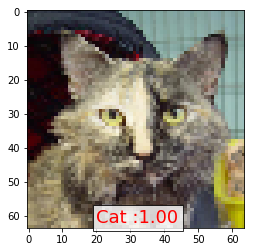

In [7]:
#Prediction of image
%matplotlib inline
import tensorflow
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
img1 = image.load_img('test/Cat/10.jpg', target_size=(64, 64))
img = image.img_to_array(img1)
img = img/255
# create a batch of size 1 [N,H,W,C]
img = np.expand_dims(img, axis=0)
prediction = classifier.predict(img, batch_size=None,steps=1) #gives all class prob.
if(prediction[:,:]>0.5):
    value ='Dog :%1.2f'%(prediction[0,0])
    plt.text(20, 62,value,color='red',fontsize=18,bbox=dict(facecolor='white',alpha=0.8))
else:
    value ='Cat :%1.2f'%(1.0-prediction[0,0])
    plt.text(20, 62,value,color='red',fontsize=18,bbox=dict(facecolor='white',alpha=0.8))

plt.imshow(img1)
plt.show()


In [8]:
import pandas as pd
test_set.reset
ytesthat = classifier.predict_generator(test_set)
df = pd.DataFrame({
    'filename':test_set.filenames,
    'predict':ytesthat[:,0],
    'y':test_set.classes
})

In [9]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)
df['y_pred'] = df['predict']>0.5
df.y_pred = df.y_pred.astype(int)
df.head(10)

,filename,predict,y,y_pred
0,Cat/0.jpg,0.00000,0,0
1,Cat/1.jpg,0.00000,0,0
2,Cat/10.jpg,0.00000,0,0
3,Cat/100.jpg,0.99970,0,1
4,Cat/10001.jpg,0.00000,0,0
5,Cat/10009.jpg,0.02340,0,0
6,Cat/1001.jpg,0.00001,0,0
7,Cat/10012.jpg,0.00000,0,0
8,Cat/10017.jpg,0.00000,0,0
9,Cat/10018.jpg,0.00000,0,0


In [10]:
misclassified = df[df['y']!=df['y_pred']]
print('Total misclassified image from 5000 Validation images : %d'%misclassified['y'].count())

Total misclassified image from 5000 Validation images : 122


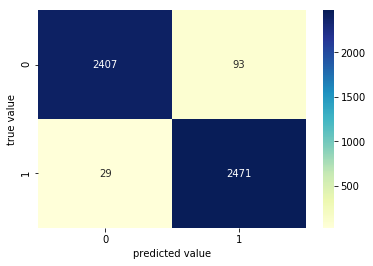

In [11]:
#Prediction of test set
from sklearn.metrics import confusion_matrix 
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = confusion_matrix(df.y,df.y_pred)
sns.heatmap(conf_matrix,cmap="YlGnBu",annot=True,fmt='g');
plt.xlabel('predicted value')
plt.ylabel('true value');

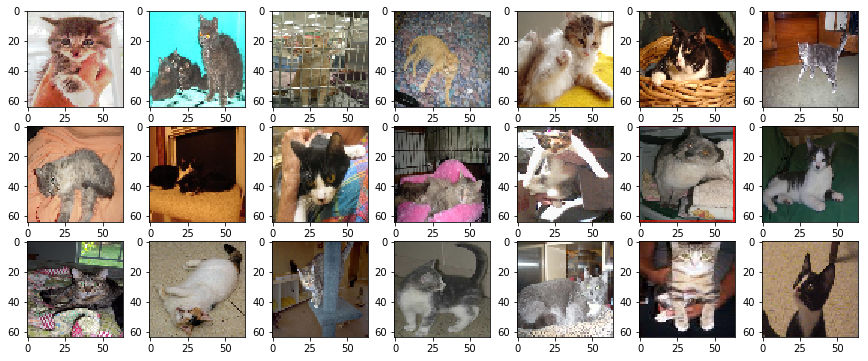

In [12]:
#Some of Cat image misclassified as Dog.
import matplotlib.image as mpimg

CatasDog = df['filename'][(df.y==0)&(df.y_pred==1)]
fig=plt.figure(figsize=(15, 6))
columns = 7
rows = 3
for i in range(columns*rows):
    #img = mpimg.imread()
    img = image.load_img('test/'+CatasDog.iloc[i], target_size=(64, 64))
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)

plt.show()


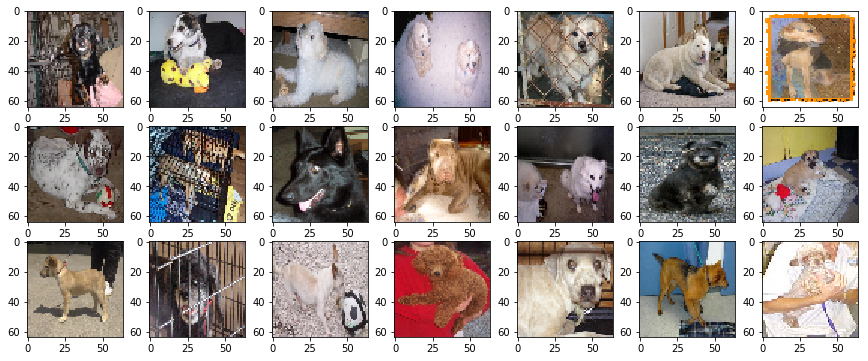

In [13]:
#Some of Dog image misclassified as Cat.
import matplotlib.image as mpimg

DogasCat = df['filename'][(df.y==1)&(df.y_pred==0)]
fig=plt.figure(figsize=(15, 6))
columns = 7
rows = 3
for i in range(columns*rows):
    #img = mpimg.imread()
    img = image.load_img('test/'+DogasCat.iloc[i], target_size=(64, 64))
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)
plt.show()


In [14]:
classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               802944    
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
Total para

### Visualization of Layers Ouptut


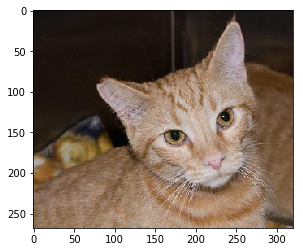

In [15]:
#Input Image for Layer visualization
img1 = image.load_img('test/Cat/14.jpg')
plt.imshow(img1);
#preprocess image
img1 = image.load_img('test/Cat/14.jpg', target_size=(64, 64))
img = image.img_to_array(img1)
img = img/255
img = np.expand_dims(img, axis=0)


In [16]:
model_layers = [ layer.name for layer in classifier.layers]
print('layer name : ',model_layers)

layer name :  ['conv2d_6', 'max_pooling2d_6', 'conv2d_7', 'max_pooling2d_7', 'flatten_3', 'dense_6', 'dense_7']


In [17]:
from tensorflow.keras.models import Model
conv2d_6_output = Model(inputs=classifier.input, outputs=classifier.get_layer('conv2d_6').output)
conv2d_7_output = Model(inputs=classifier.input,outputs=classifier.get_layer('conv2d_7').output)

In [18]:
conv2d_6_features = conv2d_6_output.predict(img)
conv2d_7_features = conv2d_7_output.predict(img)
print('First conv layer feature output shape : ',conv2d_6_features.shape)
print('First conv layer feature output shape : ',conv2d_7_features.shape)

First conv layer feature output shape :  (1, 62, 62, 32)
First conv layer feature output shape :  (1, 29, 29, 32)


### Single Convolution Filter Output

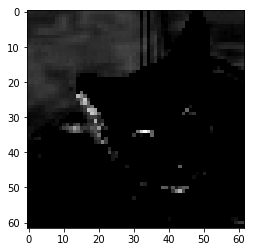

In [19]:
plt.imshow(conv2d_6_features[0, :, :, 4], cmap='gray')

### First Covolution Layer Output

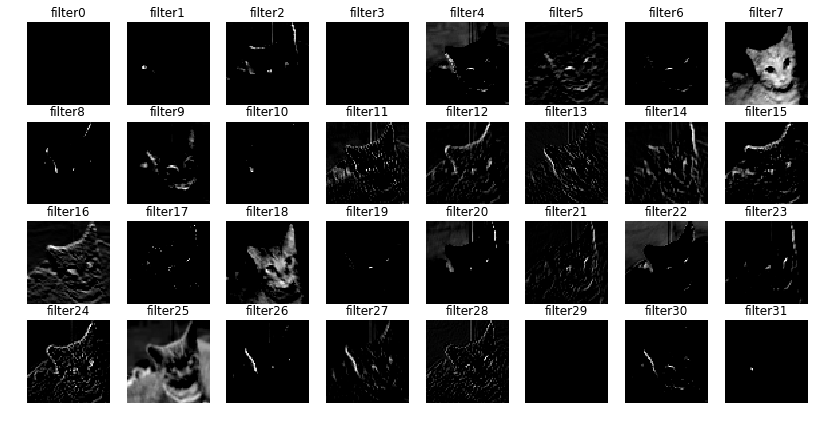

In [20]:
import matplotlib.image as mpimg

fig=plt.figure(figsize=(14,7))
columns = 8
rows = 4
for i in range(columns*rows):
    #img = mpimg.imread()
    fig.add_subplot(rows, columns, i+1)
    plt.axis('off')
    plt.title('filter'+str(i))
    plt.imshow(conv2d_6_features[0, :, :, i], cmap='gray')
plt.show()

### Second Covolution Layer Output

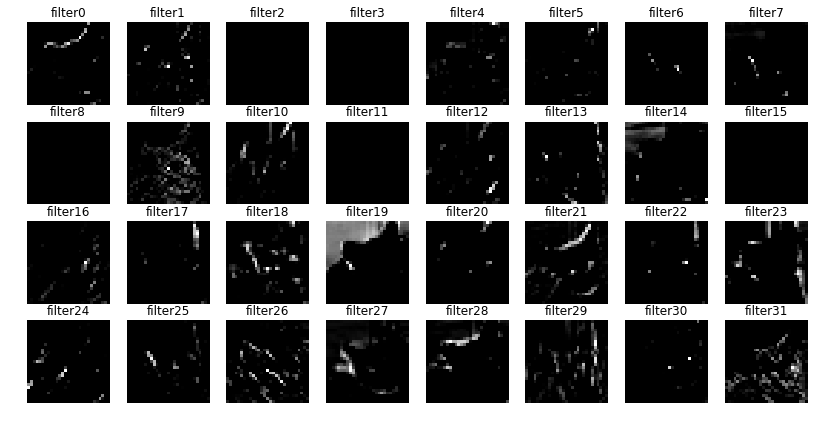

In [21]:
fig=plt.figure(figsize=(14,7))
columns = 8
rows = 4
for i in range(columns*rows):
    #img = mpimg.imread()
    fig.add_subplot(rows, columns, i+1)
    plt.axis('off')
    plt.title('filter'+str(i))
    plt.imshow(conv2d_7_features[0, :, :, i], cmap='gray')
plt.show()

### Model Performance on Unseen Data

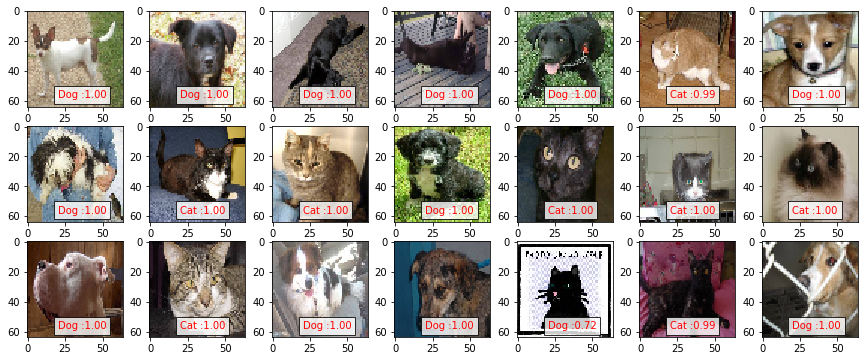

In [22]:
# for generator image set u can use 
# ypred = classifier.predict_generator(test_set)

fig=plt.figure(figsize=(15, 6))
columns = 7
rows = 3
for i in range(columns*rows):
    fig.add_subplot(rows, columns, i+1)
    img1 = image.load_img('test1/'+test_set1.filenames[np.random.choice(range(12500))], target_size=(64, 64))
    img = image.img_to_array(img1)
    img = img/255
    img = np.expand_dims(img, axis=0)
    prediction = classifier.predict(img, batch_size=None,steps=1) #gives all class prob.
    if(prediction[:,:]>0.5):
        value ='Dog :%1.2f'%(prediction[0,0])
        plt.text(20, 58,value,color='red',fontsize=10,bbox=dict(facecolor='white',alpha=0.8))
    else:
        value ='Cat :%1.2f'%(1.0-prediction[0,0])
        plt.text(20, 58,value,color='red',fontsize=10,bbox=dict(facecolor='white',alpha=0.8))
    plt.imshow(img1)


In [23]:
%%capture
# Model Accuracy
x1 = classifier.evaluate_generator(train_set)
x2 = classifier.evaluate_generator(test_set)

In [24]:
print('Training Accuracy  : %1.2f%%     Training loss  : %1.6f'%(x1[1]*100,x1[0]))
print('Validation Accuracy: %1.2f%%     Validation loss: %1.6f'%(x2[1]*100,x2[0]))

Training Accuracy  : 99.96%     Training loss  : 0.002454
Validation Accuracy: 97.56%     Validation loss: 0.102678


### Conclusion
The Architecture and parameter used in this network are capable of producing accuracy of **97.56%** on Validation Data which is pretty good. It is possible to Achieve more accuracy on this dataset using deeper network and fine tuning of network parameters for training. You can download this trained model from resource directory and Play with it. 